In [1]:
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns

import distributions
import pacing
import simulation

In [2]:
camp_imps = 100_000
camp_num = 2

camps_params = [pacing.CampaignParams(i, i, camp_imps, camp_imps * i)
                for i in range(1, camp_num + 1)]

In [3]:
reqs = sum(p.imps_target for p in camps_params)
ticks = 24 * 60

base_dist = distributions.custom_dist(ticks)
# base_dist = distributions.uniform_dist(ticks)
traffic_dist = distributions.traffic_dist(base_dist, reqs)

In [4]:
asap_p = pacing.AsapPacer()
equal_p = pacing.EqualPacer(ticks)
throttled_p = pacing.ThrottledPacer(traffic_dist)
throttled_ff_p = pacing.ThrottledPacer(traffic_dist, True)

In [5]:
def scenario(traffic_dist: np.ndarray, pacer: pacing.Pacer, camps_params: List[pacing.CampaignParams]) -> Tuple[
    simulation.Simulation, simulation.EventCollector]:
    ec = simulation.EventCollector()
    ad_srv = pacing.AdServer(ec, traffic_dist, pacer, camps_params)
    sim = simulation.Simulation(ticks, ad_srv)

    return sim, ec

In [6]:
asap_scn = scenario(traffic_dist, asap_p, camps_params)
equal_scn = scenario(traffic_dist, equal_p, camps_params)
throttled_scn = scenario(traffic_dist, throttled_p, camps_params)
throttled_ff_scn = scenario(traffic_dist, throttled_ff_p, camps_params)

In [7]:
asap_scn[0].run()
equal_scn[0].run()
throttled_scn[0].run()
throttled_ff_scn[0].run()

In [8]:
def prepare_data(events: List[pacing.Event], camps_params: List[pacing.CampaignParams]):
    records = pd.DataFrame.from_records([(e.tick, e.data.campaign_id, e.data.value) for e in events],
                                        columns=["time", "campaign", "value"])
    params = pd.DataFrame.from_records([(cp.ID, cp.budget_limit, cp.imps_target) for cp in camps_params],
                                       columns=["campaign", "budget_limit", "imps_target"]).set_index("campaign")

    agg = records.groupby(["time", "campaign"]).agg(spent=("value", np.sum), imps=("value", np.size))
    df = agg.join(params, on="campaign")
    df["spent_norm"] = df["spent"] / df["budget_limit"]
    df["imps_norm"] = df["imps"] / df["imps_target"]
    df["avg_value"] = df["spent"] / df["imps"]

    return df


asap_data = prepare_data(asap_scn[1].fetch(pacing.AuctionEvents.WIN), camps_params)
equal_data = prepare_data(equal_scn[1].fetch(pacing.AuctionEvents.WIN), camps_params)
throttled_data = prepare_data(throttled_scn[1].fetch(pacing.AuctionEvents.WIN), camps_params)
throttled_ff_data = prepare_data(throttled_ff_scn[1].fetch(pacing.AuctionEvents.WIN), camps_params)

asap_data.sample(10)

,,spent,imps,budget_limit,imps_target,spent_norm,imps_norm,avg_value
time,campaign,,,,,,,
40,2,26,13,200000,100000,0.00013,0.00013,2.0
1390,1,127,127,100000,100000,0.00127,0.00127,1.0
1268,1,267,267,100000,100000,0.00267,0.00267,1.0
1419,1,97,97,100000,100000,0.00097,0.00097,1.0
1211,1,305,305,100000,100000,0.00305,0.00305,1.0
872,2,86,43,200000,100000,0.00043,0.00043,2.0
1103,1,271,271,100000,100000,0.00271,0.00271,1.0
1246,1,286,286,100000,100000,0.00286,0.00286,1.0
381,2,436,218,200000,100000,0.00218,0.00218,2.0


In [9]:
def plot_spent_norm(df: pd.DataFrame):
    cf = df.unstack(level=1, fill_value=0).cumsum()
    sns.relplot(data=cf["spent_norm"], kind="line")

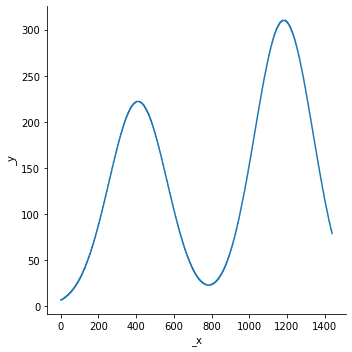

In [10]:
sns.relplot(data=traffic_dist, kind="line")

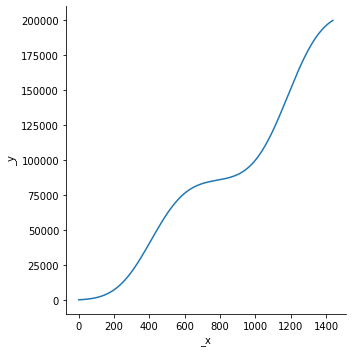

In [11]:
sns.relplot(data=traffic_dist.cumsum(), kind="line")

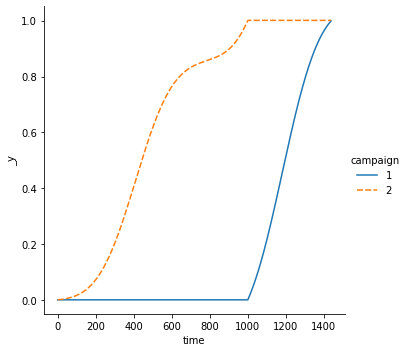

In [12]:
plot_spent_norm(asap_data)

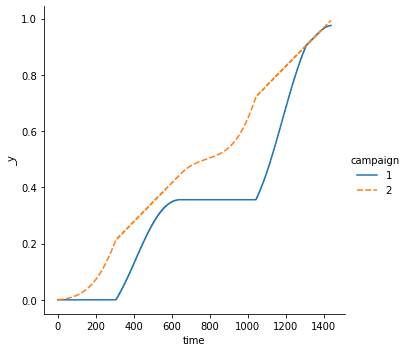

In [13]:
plot_spent_norm(equal_data)

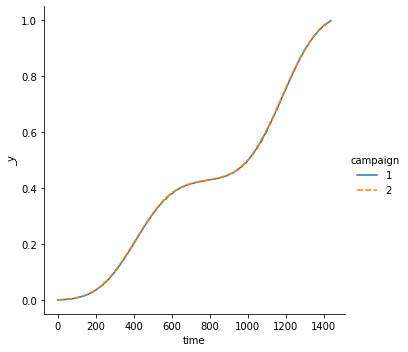

In [14]:
plot_spent_norm(throttled_data)

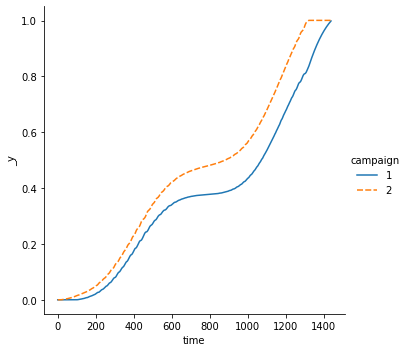

In [15]:
plot_spent_norm(throttled_ff_data)

<AxesSubplot:>

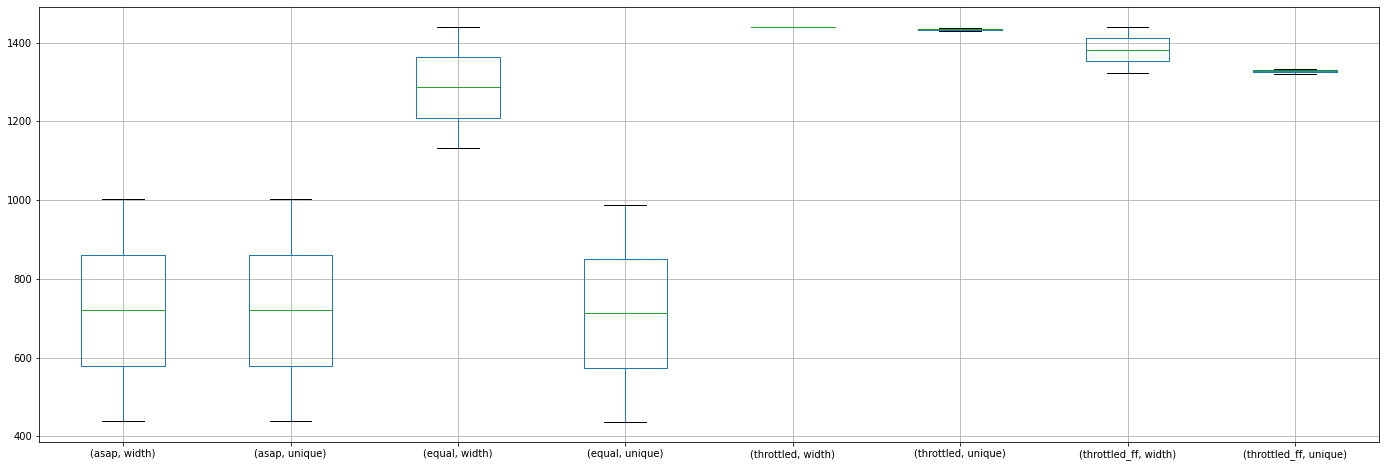

In [16]:
def analysis_time_windows(df: pd.DataFrame):
    return df.reset_index().groupby("campaign").agg(width=("time", lambda x: np.max(x) - np.min(x) + 1),
                                                    unique=("time", pd.Series.nunique))


asap_tw = analysis_time_windows(asap_data)
equal_tw = analysis_time_windows(equal_data)
throttled_tw = analysis_time_windows(throttled_data)
throttled_ff_tw = analysis_time_windows(throttled_ff_data)

results_tw = pd.concat({"asap": asap_tw, "equal": equal_tw, "throttled": throttled_tw, 'throttled_ff': throttled_ff_tw},
                       axis=1, names=["pacer", "metric"]).fillna(0)

results_tw.boxplot(figsize=(24, 8))

<AxesSubplot:>

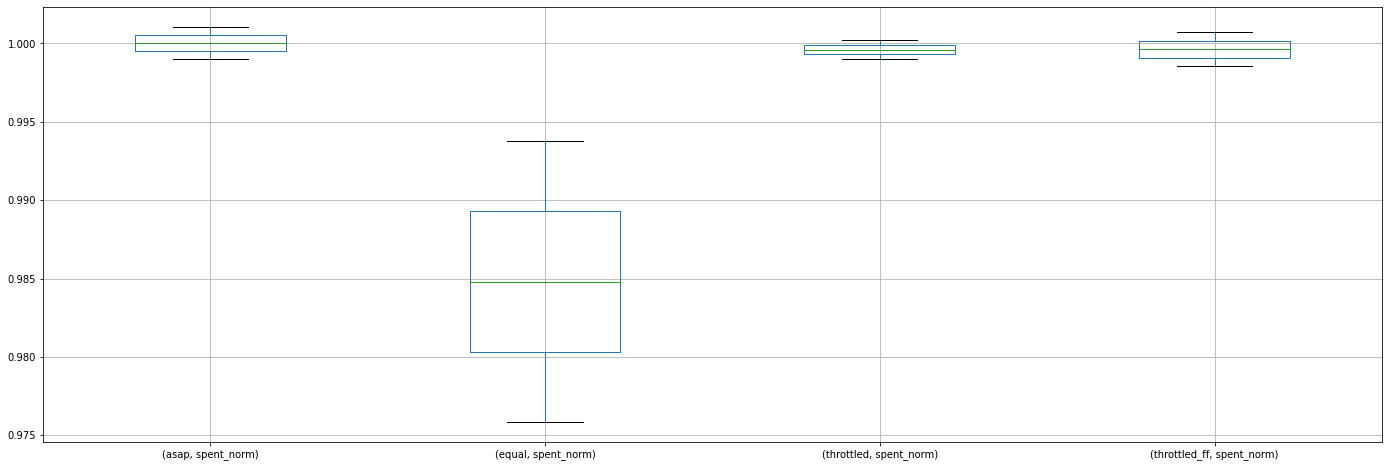

In [17]:
def analysis_budgets(df: pd.DataFrame):
    return df.reset_index().groupby("campaign").agg(spent_norm=("spent_norm", np.sum))


results_spent = pd.concat({"asap": analysis_budgets(asap_data), "equal": analysis_budgets(equal_data),
                           "throttled": analysis_budgets(throttled_data),
                           "throttled_ff": analysis_budgets(throttled_ff_data)}, axis=1,
                          names=["pacer", "metric"]).fillna(0)

results_spent.boxplot(figsize=(24, 8))

In [18]:
results_spent[results_spent > 1].count()

pacer         metric    
asap          spent_norm    1
equal         spent_norm    0
throttled     spent_norm    1
throttled_ff  spent_norm    1
dtype: int64

In [19]:
results_spent[results_spent < 1].count()

pacer         metric    
asap          spent_norm    1
equal         spent_norm    2
throttled     spent_norm    1
throttled_ff  spent_norm    1
dtype: int64

In [20]:
def analysis_returns(df: pd.DataFrame, reqs: int):
    s = df[["spent", "imps"]].sum()
    s.index = ["earned", "imps"]
    s.loc["avg_price"] = s.loc["earned"] / s.loc["imps"]
    s.loc["fill_rate"] = s.loc["imps"] / reqs
    return s


pd.concat({"asap": analysis_returns(asap_data, reqs), "equal": analysis_returns(equal_data, reqs),
           "throttled": analysis_returns(throttled_data, reqs),
           "throttled_ff": analysis_returns(throttled_ff_data, reqs)}, axis=1, names=["pacer"])

pacer,asap,equal,throttled,throttled_ff
earned,300115.000000,296340.000000,299938.000000,299998.000000
imps,200009.000000,196962.000000,199919.000000,199927.000000
avg_price,1.500507,1.504554,1.500298,1.500538
fill_rate,1.000045,0.984810,0.999595,0.999635


In [21]:
def plot_avg_value(df: pd.DataFrame):
    a = df.groupby("time").aggregate(value=("spent", np.sum), imps=("imps", np.sum))
    a["avg_value"] = a["value"] / a["imps"]

    (a["value"] / a["imps"]).plot(figsize=(24, 8))

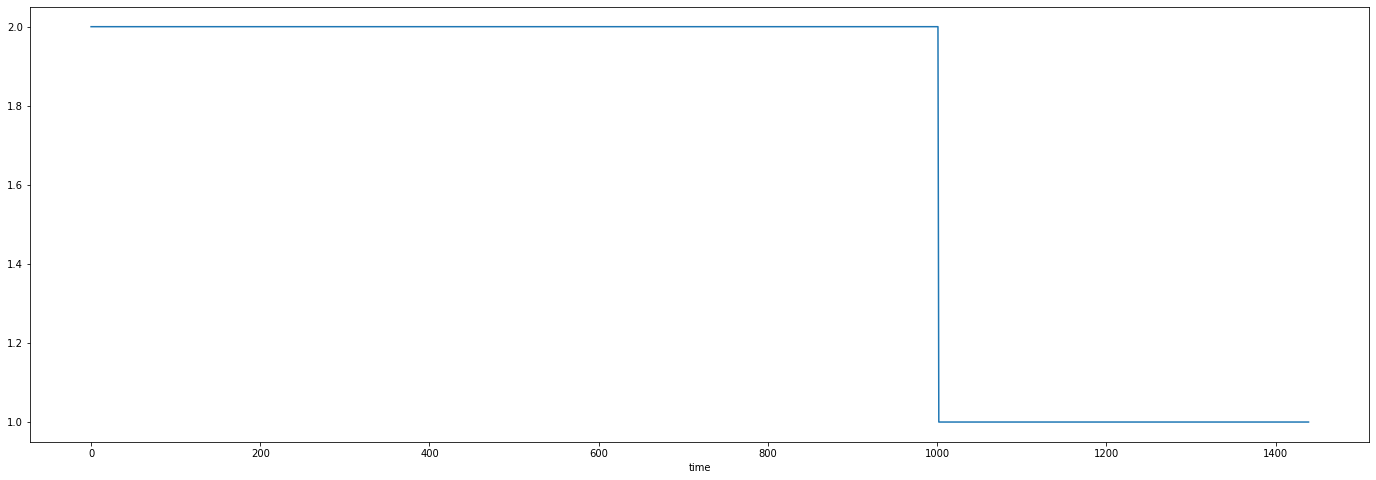

In [22]:
plot_avg_value(asap_data)

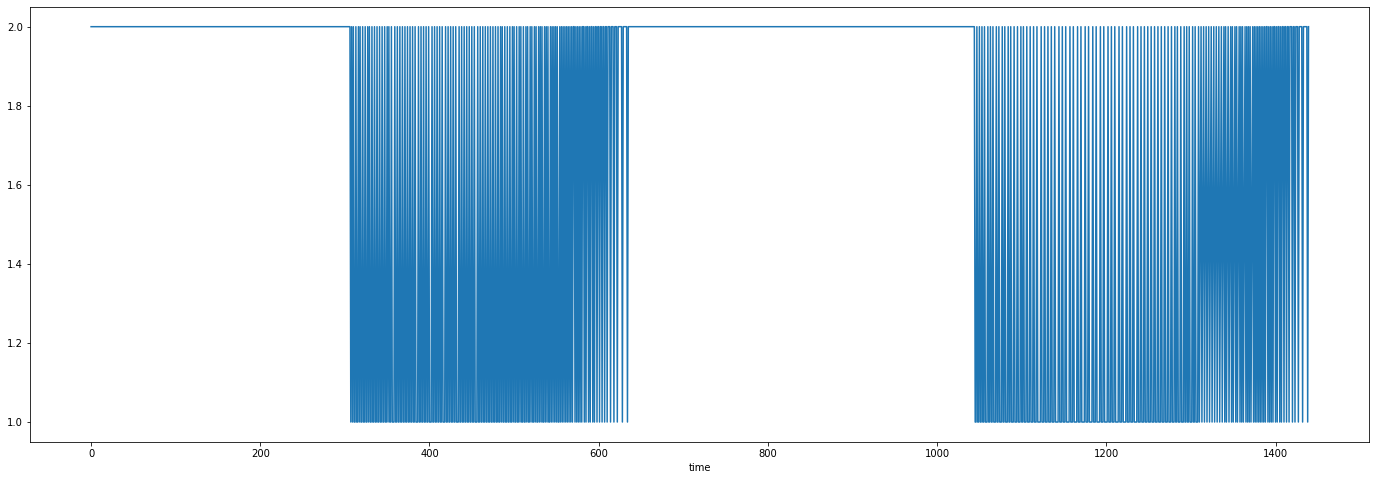

In [23]:
plot_avg_value(equal_data)

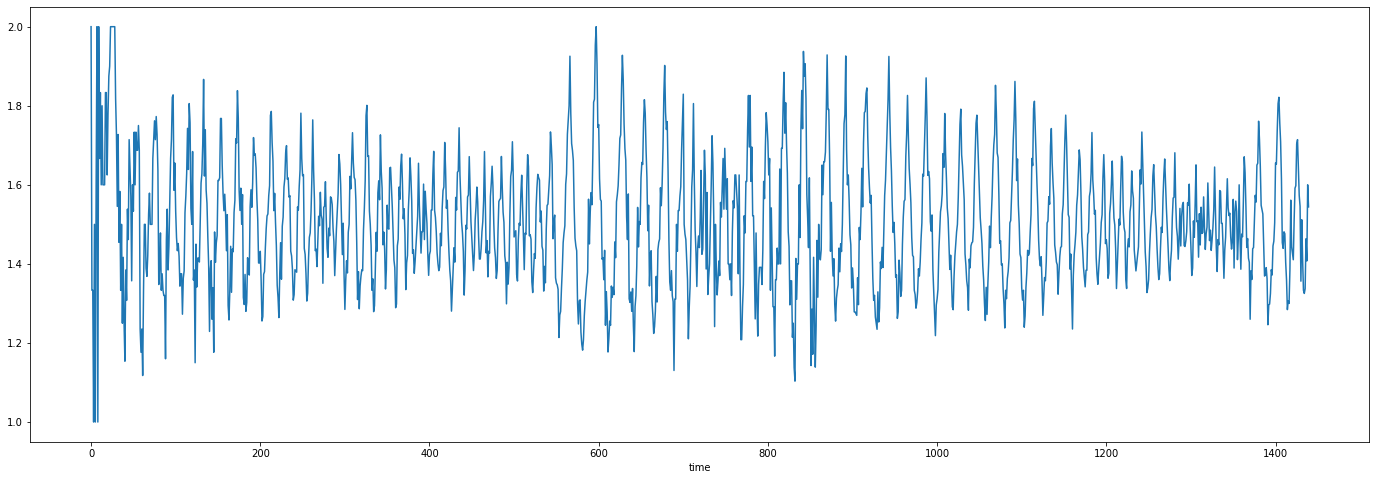

In [24]:
plot_avg_value(throttled_data)

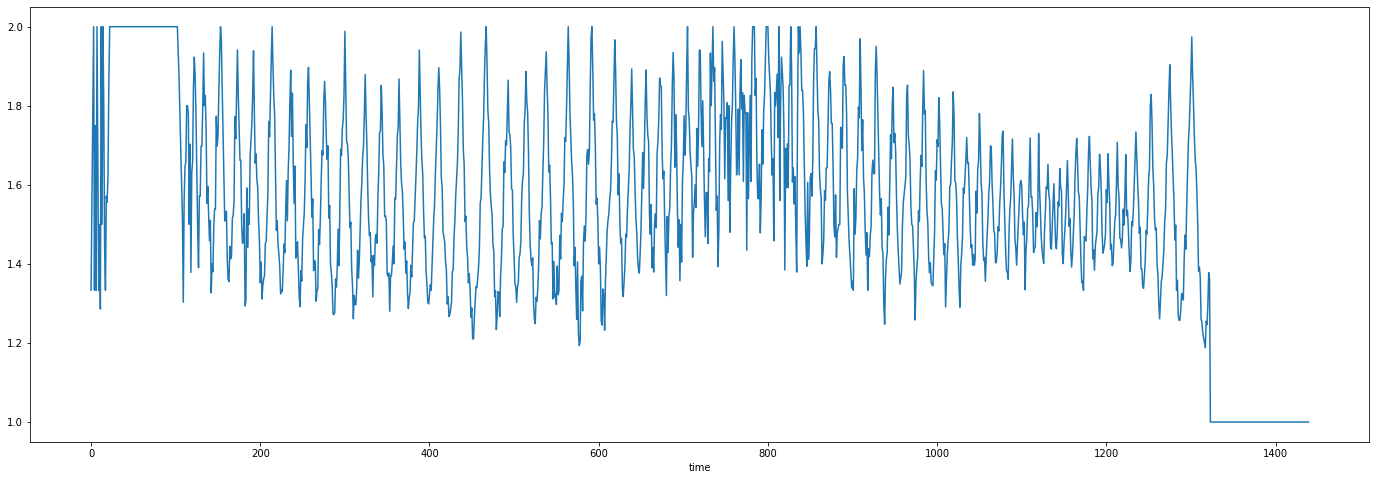

In [25]:
plot_avg_value(throttled_ff_data)